In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-white')

## Simple linear regression

In [3]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

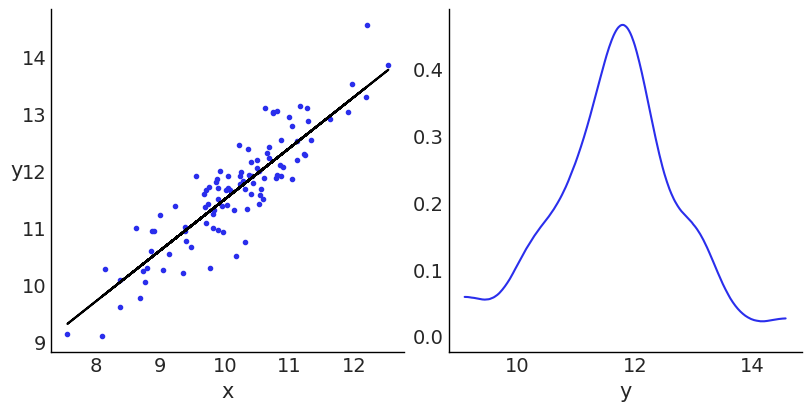

In [4]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.savefig('B11197_03_02.png')

In [5]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_g = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


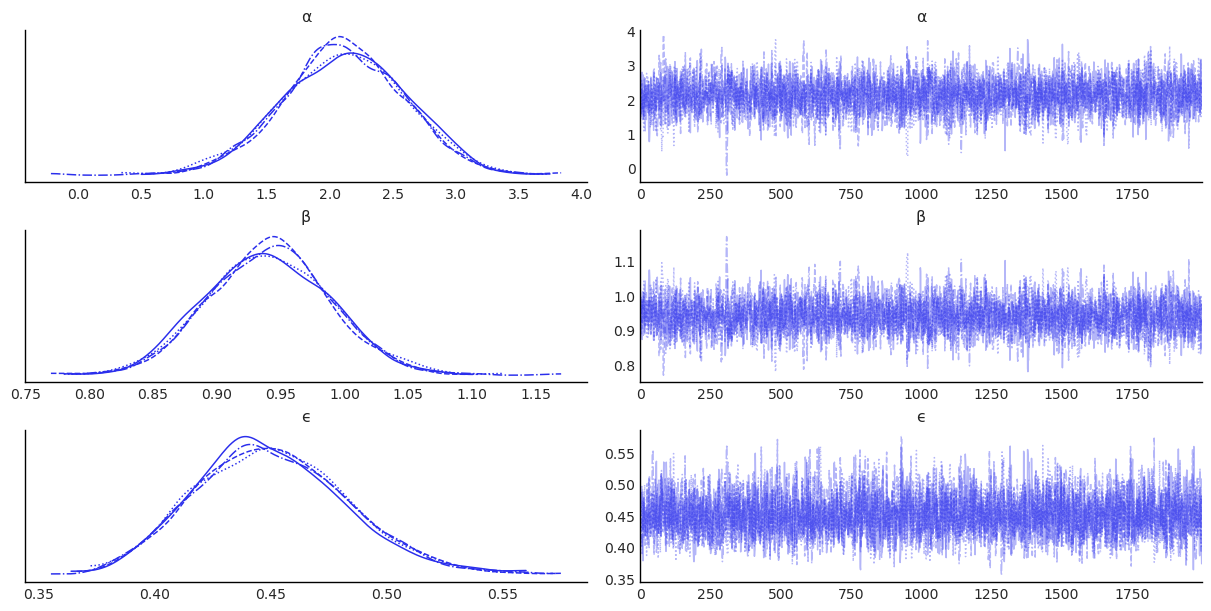

In [6]:
az.plot_trace(idata_g, var_names=['α', 'β', 'ϵ'])
plt.savefig('B11197_03_03.png')

### Modyfing the data before running the models

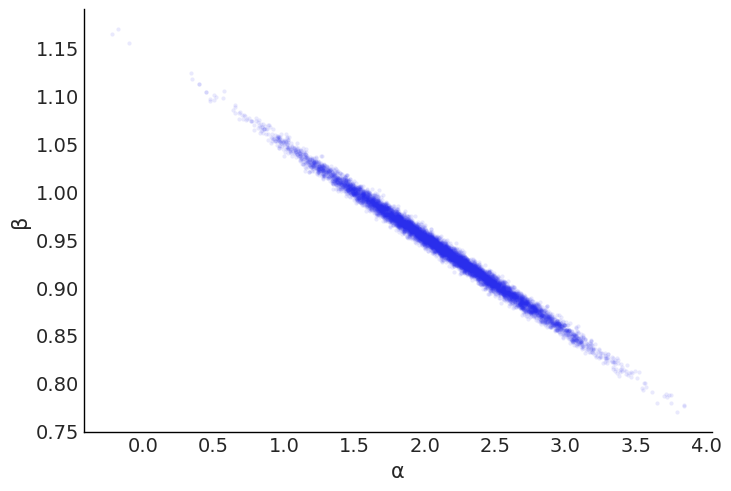

In [7]:
az.plot_pair(idata_g, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.1})
plt.savefig('B11197_03_04.png')

### interpreting the posterior

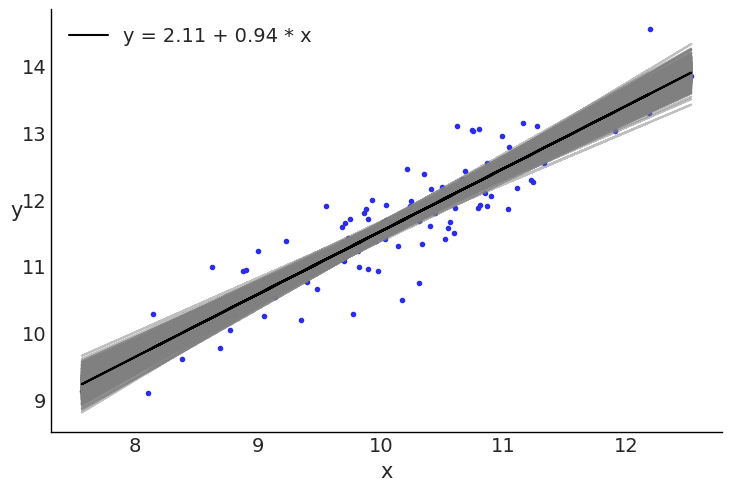

In [8]:
plt.plot(x, y, 'C0.')

posterior_g = az.extract(idata_g)
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()

draws = range(0, posterior_g.sample.size, 10)
plt.plot(x, posterior_g['α'][draws].values + posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.savefig('B11197_03_05.png')

/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


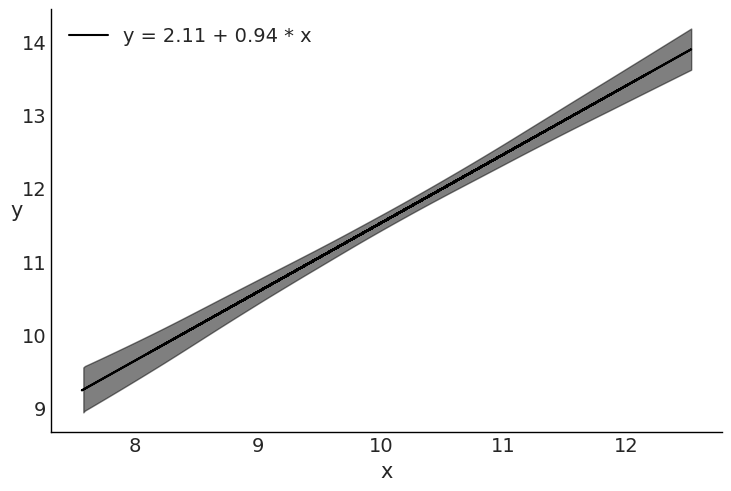

In [9]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(x, posterior_g['μ'].T, hdi_prob=0.98, color='k')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.savefig('B11197_03_06.png')

In [10]:
ppc = pm.sample_posterior_predictive(idata_g, model=model_g)

Sampling: [y_pred]


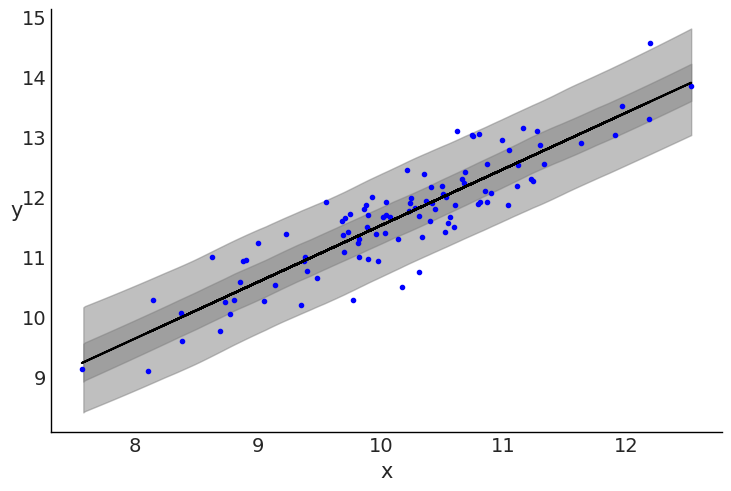

In [11]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x, ppc.posterior_predictive['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, ppc.posterior_predictive['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_07.png')

In [12]:
az.r2_score(y, az.extract(ppc, group="posterior_predictive", var_names="y_pred").values.T)

r2        0.709019
r2_std    0.033561
dtype: float64

### The multivariate normal distribution 
Actually the bivariate

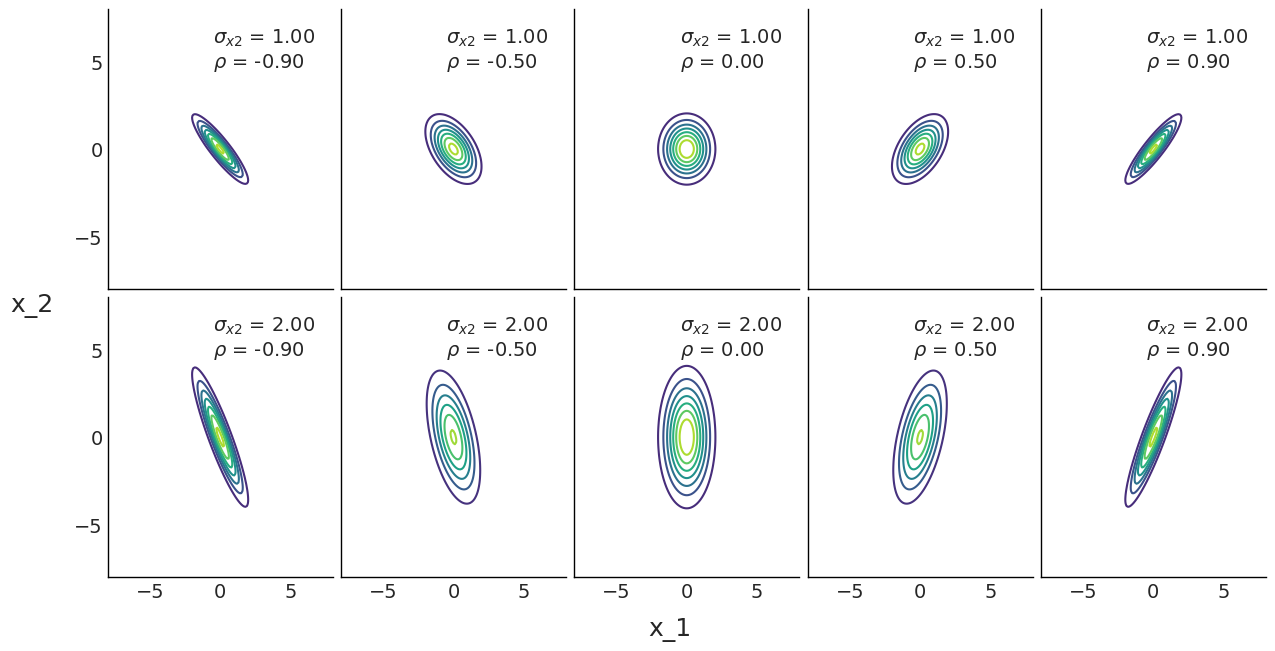

In [13]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
                      label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)
plt.savefig('B11197_03_08.png')

In [14]:
data = np.stack((x, y)).T
with pm.Model() as pearson_model:

    μ = pm.Normal('μ', mu=data.mean(0), sigma=10, shape=2)

    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2)

    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
                         [σ_1*σ_2*ρ, σ_2**2]))

    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)

    idata_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ_1, σ_2, ρ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


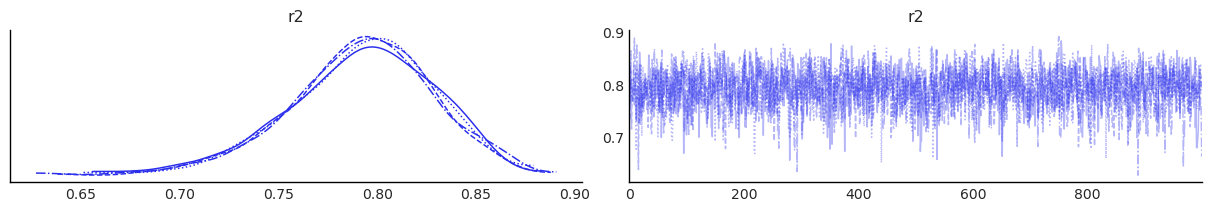

In [15]:
az.plot_trace(idata_p, var_names=['r2'])
plt.savefig('B11197_03_9.png')

In [16]:
az.summary(idata_p, var_names=['r2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r2,0.792,0.037,0.719,0.857,0.001,0.001,2137.0,2450.0,1.0


## Robust linear regression

In [17]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

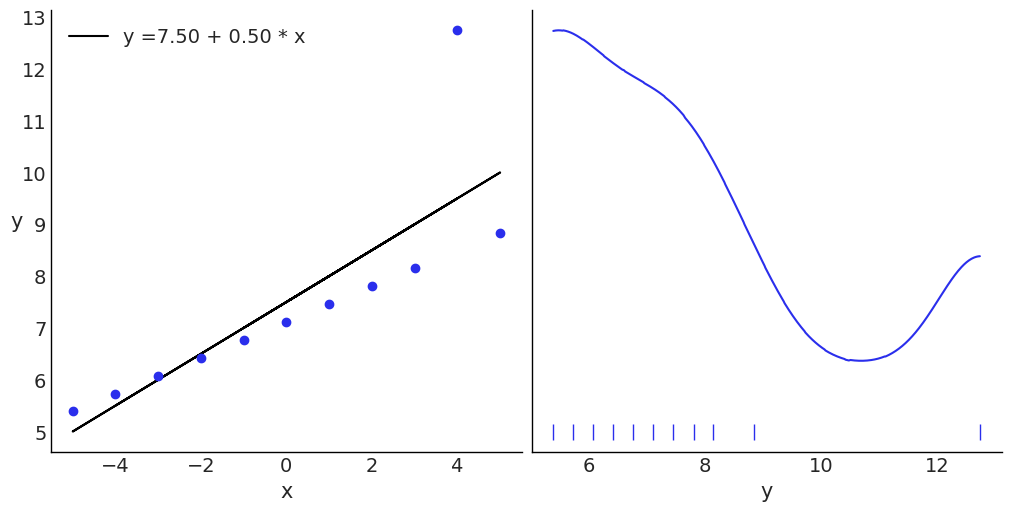

In [18]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.savefig('B11197_03_10.png')

In [19]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sigma=1)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sigma=ϵ, nu=ν, observed=y_3)

    idata_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ, ν_]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


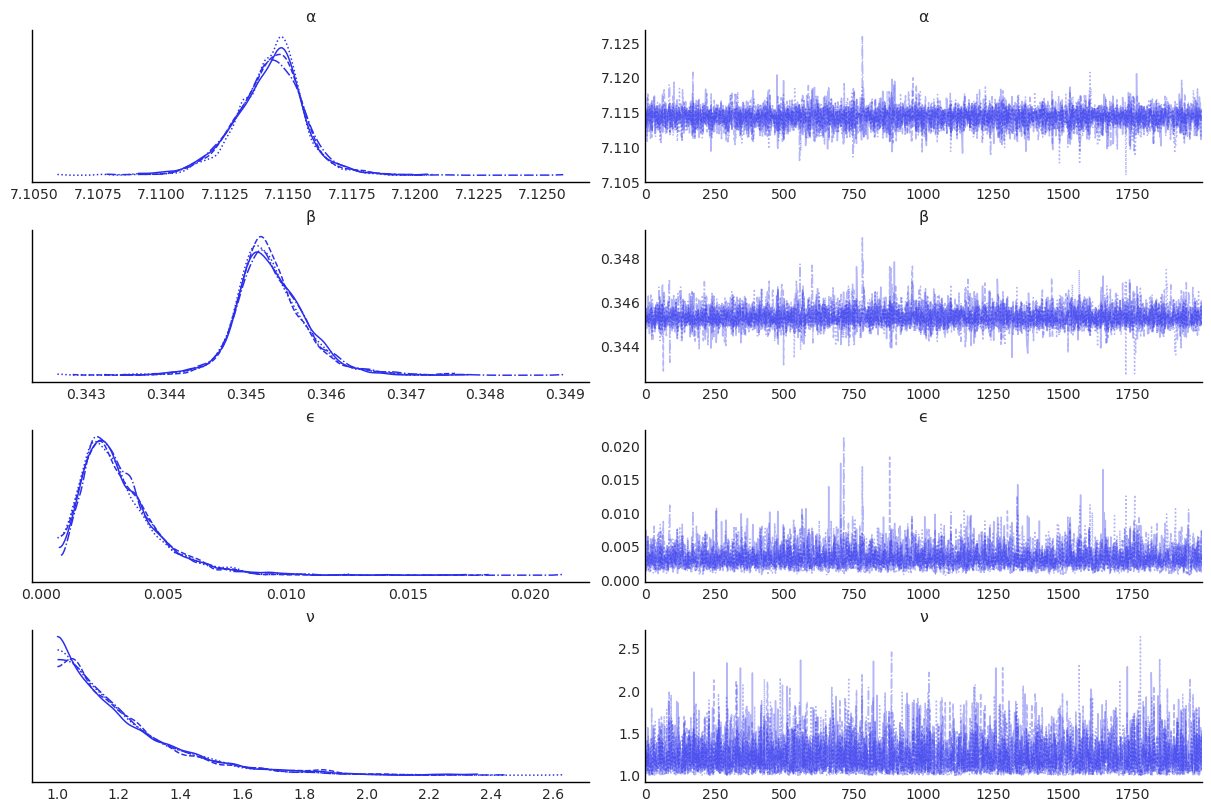

In [20]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(idata_t, var_names=varnames);

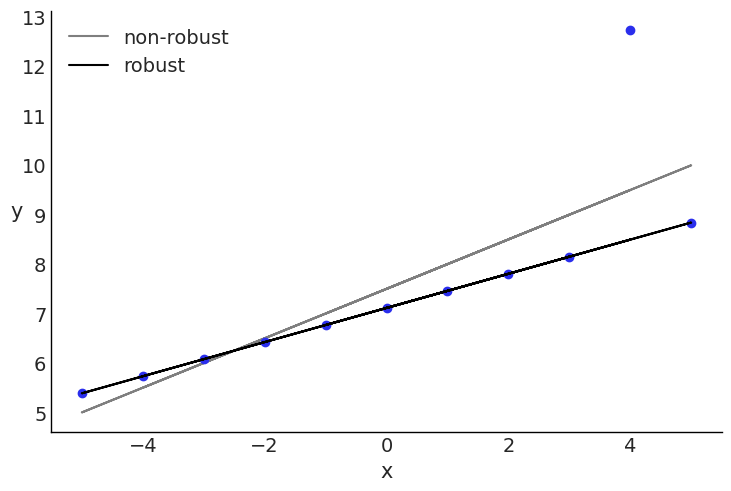

In [21]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

posterior_mean = az.extract(idata_t).mean()

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = posterior_mean['α'].item()
beta_m = posterior_mean['β'].item()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)

plt.savefig('B11197_03_11.png')

In [22]:
az.summary(idata_t, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.111,7.117,0.000,0.000,5624.0,4153.0,1.0
β,0.345,0.000,0.344,0.346,0.000,0.000,4767.0,4015.0,1.0
ϵ,0.003,0.002,0.001,0.006,0.000,0.000,2990.0,2004.0,1.0
ν,1.211,0.197,1.000,1.571,0.002,0.002,3656.0,2065.0,1.0


In [23]:
pm.sample_posterior_predictive(idata_t, model=model_t, random_seed=2, extend_inferencedata=True)

Sampling: [y_pred]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

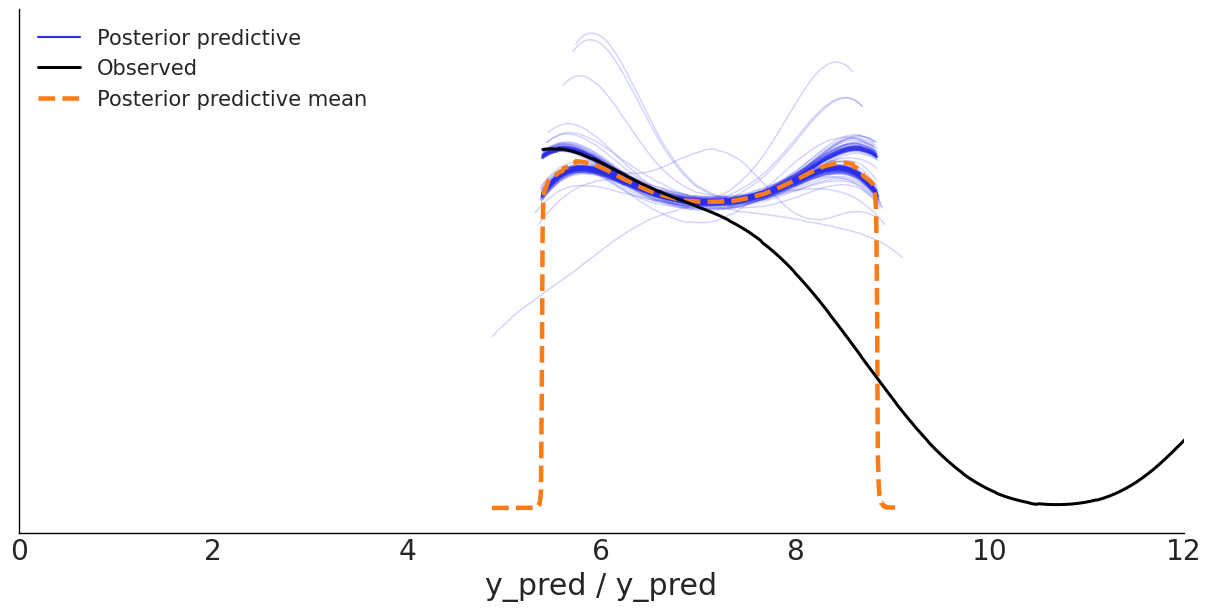

In [24]:
ax = az.plot_ppc(idata_t, num_pp_samples=200, figsize=(12, 6), mean=True)
plt.xlim(0, 12)
plt.savefig('B11197_03_12.png')

## Hierarchical linear regression

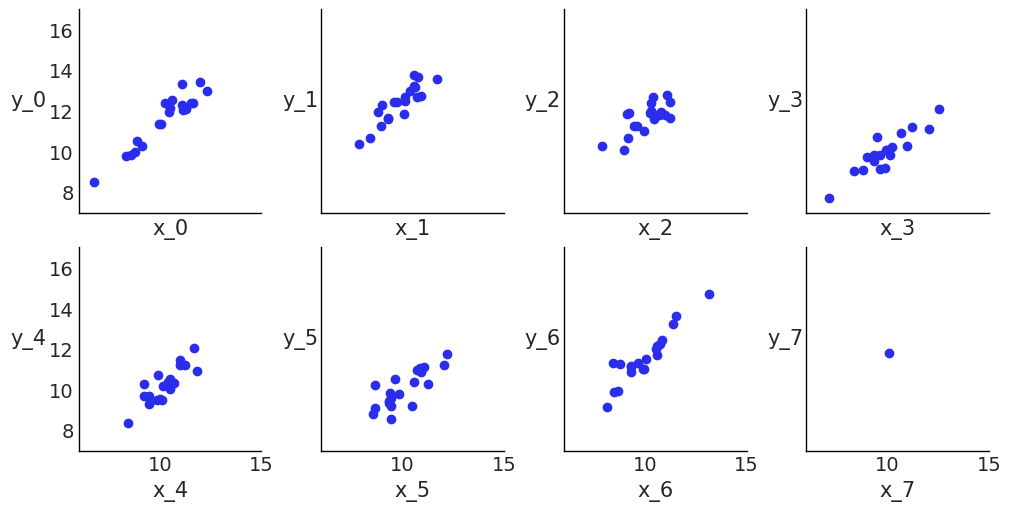

In [25]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.savefig('B11197_03_13.png')

In [26]:
x_centered = x_m - x_m.mean()

In [27]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    idata_up = pm.sample(2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


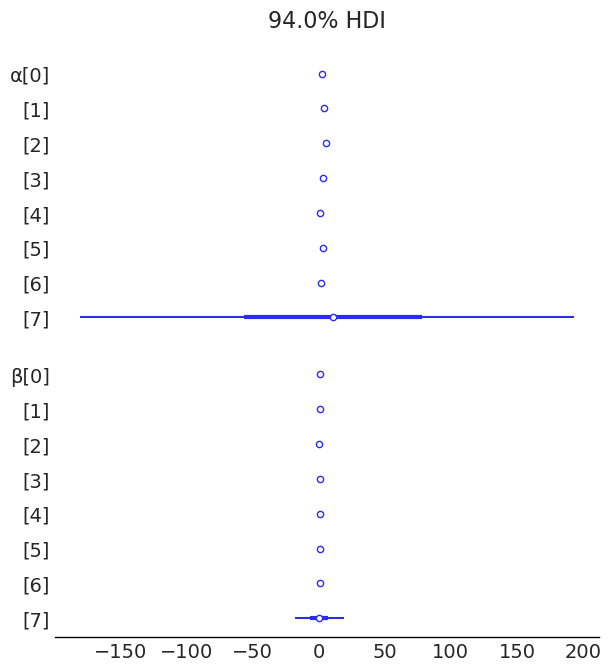

In [28]:
az.plot_forest(idata_up, var_names=['α', 'β'], combined=True)
plt.savefig('B11197_03_14.png')


 <img src='B11197_03_15.png' width="700">

In [29]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=10)
    β_σ = pm.HalfNormal('β_σ', sigma=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    idata_hm = pm.sample(2000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.


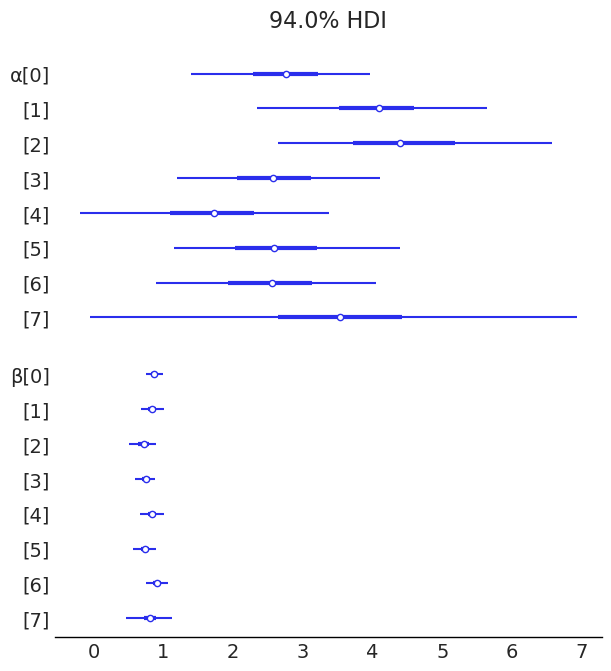

In [30]:
az.plot_forest(idata_hm, var_names=['α', 'β'], combined=True)
plt.savefig('B11197_03_16.png')

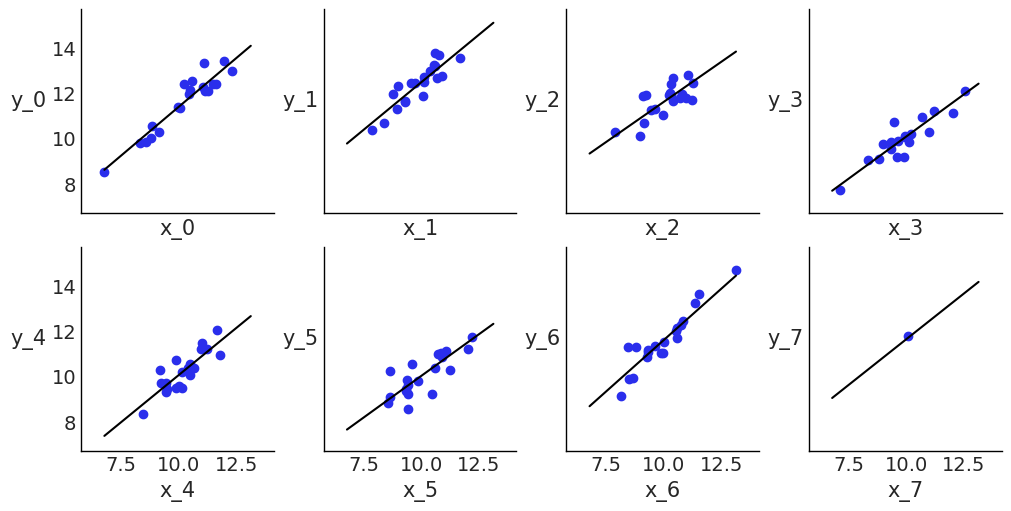

In [31]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)

posterior_hm = az.extract(idata_hm)

for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = posterior_hm["α"].sel({"α_dim_0":i}).mean().item()
    beta_m = posterior_hm["β"].sel({"β_dim_0":i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.savefig('B11197_03_17.png')

## Polynomial regression

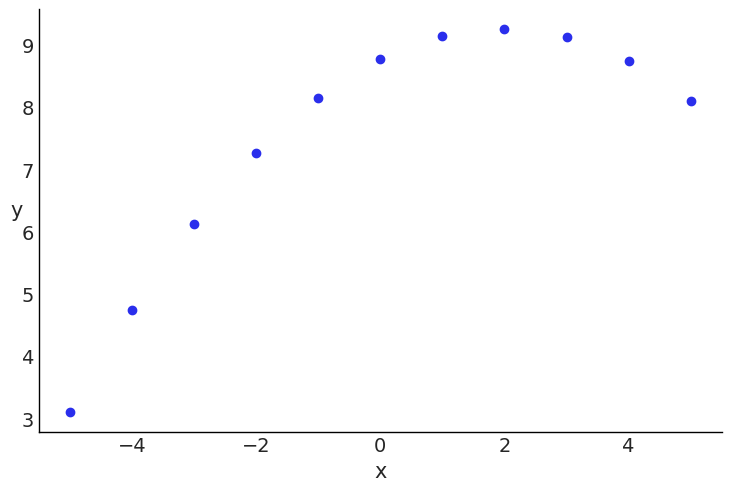

In [32]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_18.png')

In [33]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sigma=1)
    β1 = pm.Normal('β1', mu=0, sigma=1)
    β2 = pm.Normal('β2', mu=0, sigma=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β1 * x_2 + β2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sigma=ϵ, observed=y_2)

    idata_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [34]:
#az.plot_trace(idata_poly);

In [35]:
#az.summary(idata_poly)

In [36]:
idata_poly.posterior['α'].mean()

<xarray.DataArray 'α' ()>
array(8.76801603)

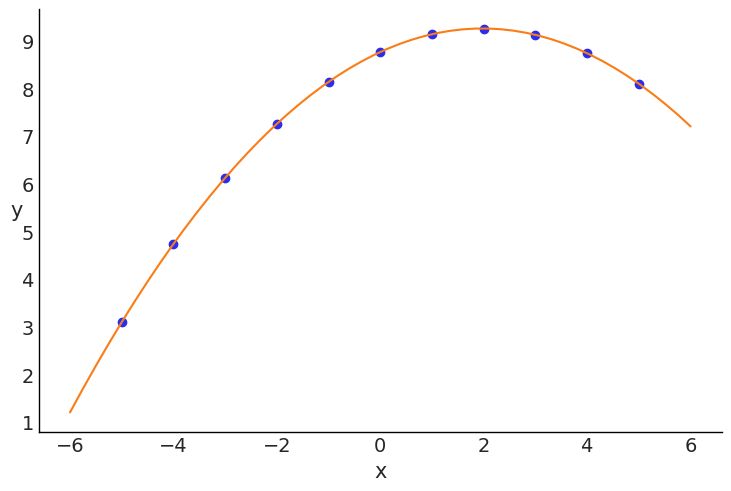

In [37]:
x_p = np.linspace(-6, 6)
y_p = idata_poly.posterior['α'].mean().item() + idata_poly.posterior['β1'].mean().item() * \
    x_p + idata_poly.posterior['β2'].mean().item() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B11197_03_19.png')

## Multiple Linear regression

In [38]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

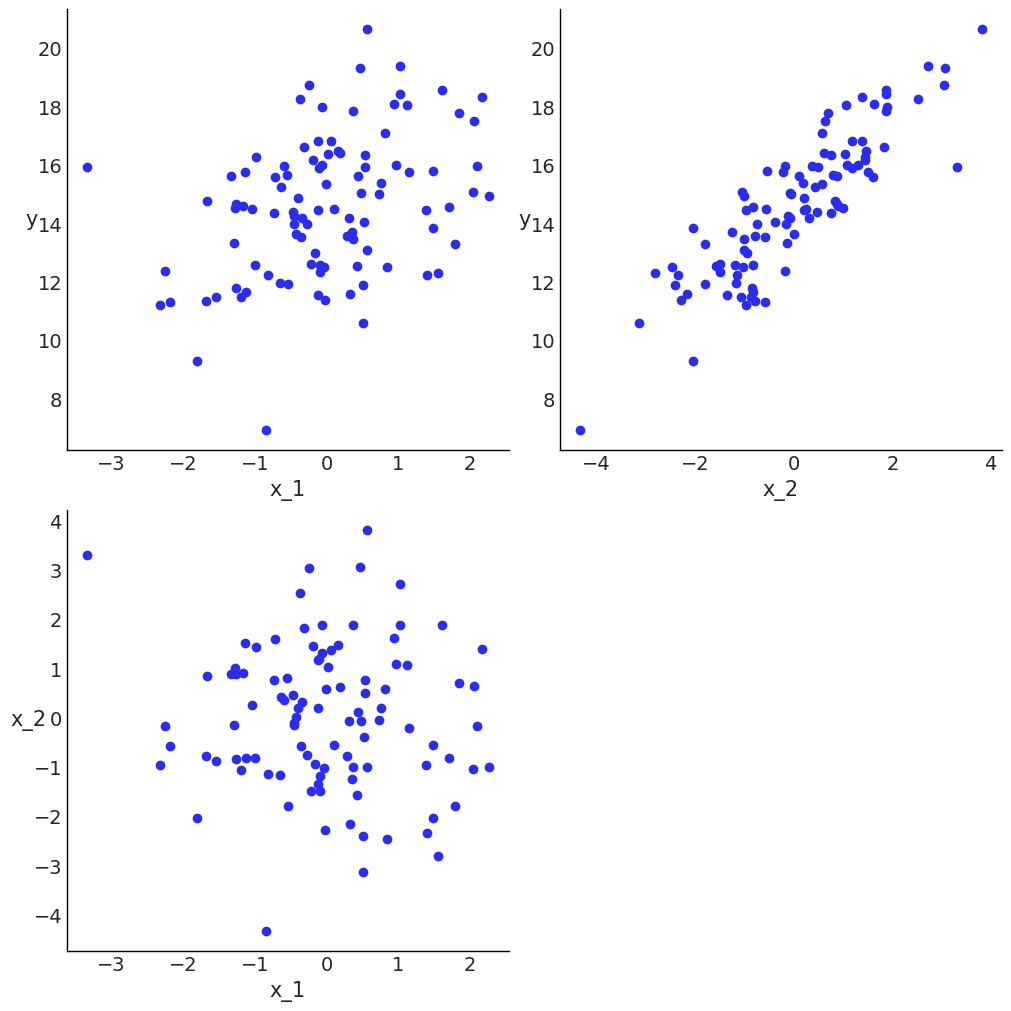

In [39]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)
plt.savefig('B11197_03_20.png')

In [40]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [41]:
varnames = ['α', 'β', 'ϵ']
#az.plot_trace(idata_mlr, var_names=varnames);

In [42]:
az.summary(idata_mlr, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.844,0.457,0.981,2.695,0.004,0.003,12535.0,5710.0,1.0
β[0],0.970,0.044,0.891,1.056,0.000,0.000,12818.0,5828.0,1.0
β[1],1.469,0.033,1.405,1.527,0.000,0.000,12418.0,6398.0,1.0
ϵ,0.475,0.034,0.411,0.538,0.000,0.000,10310.0,6311.0,1.0


## Confounding variables and redundant variables

In [43]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

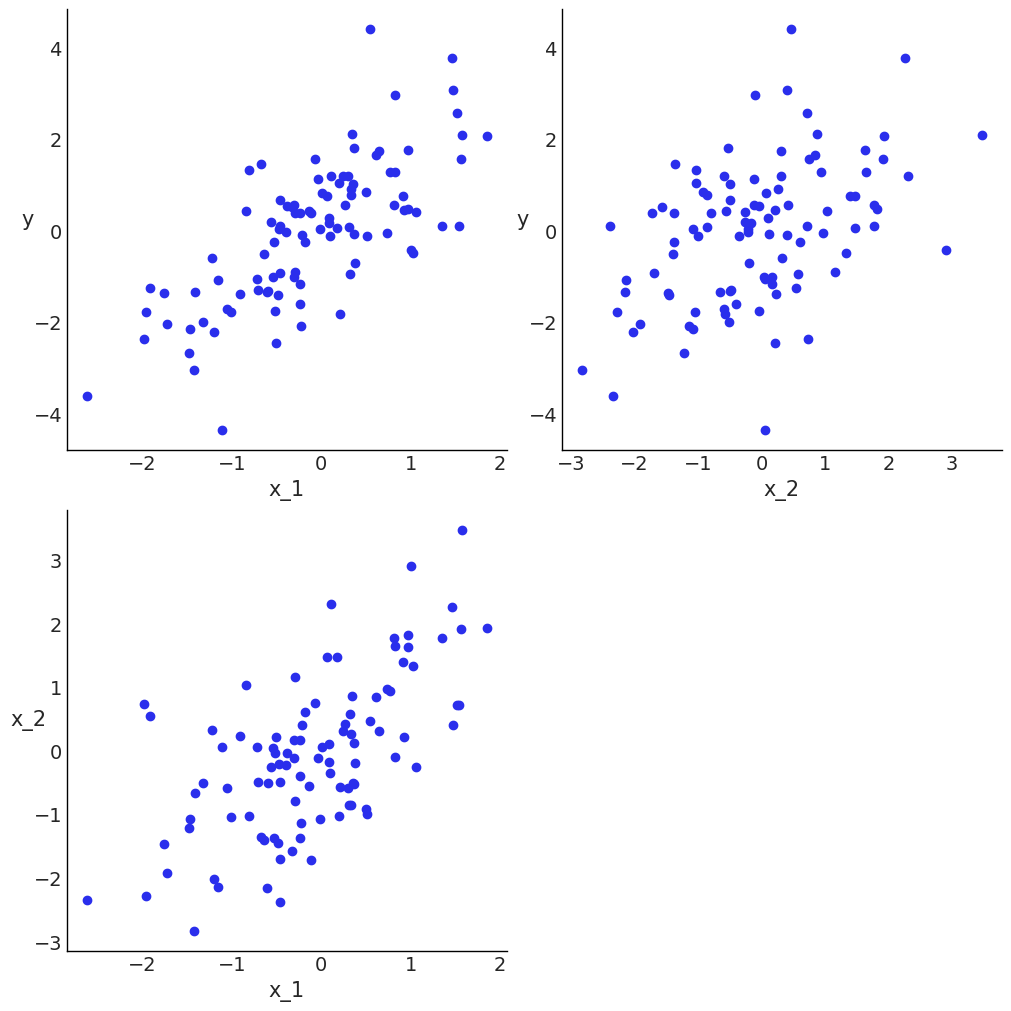

In [44]:
scatter_plot(X, y)
plt.savefig('B11197_03_21.png')

In [45]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β2, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


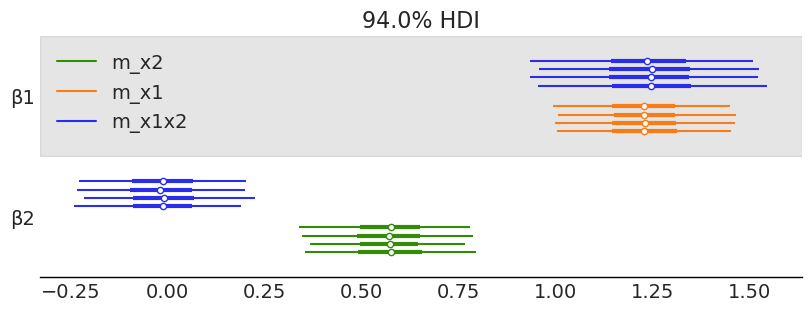

In [46]:
az.plot_forest([idata_x1x2, idata_x1, idata_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_22.png')

In [47]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

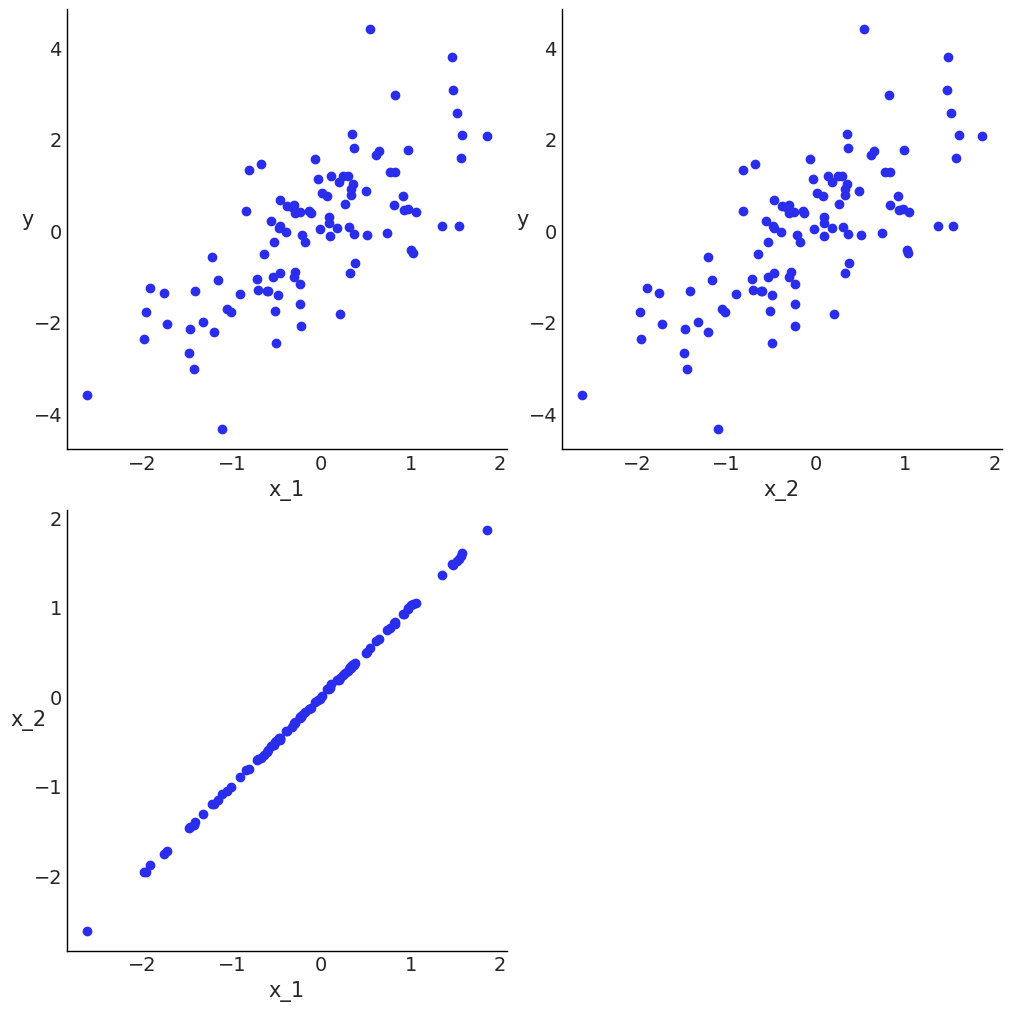

In [48]:
scatter_plot(X, y)
plt.savefig('B11197_03_23.png')

In [49]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_red = pm.sample(2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 76 seconds.


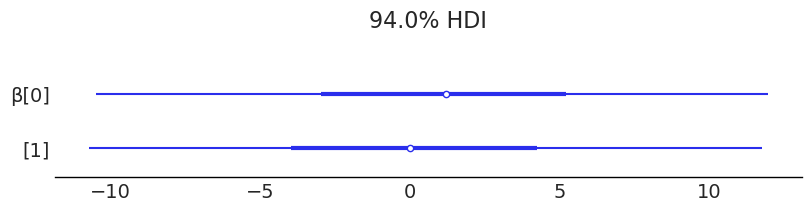

In [50]:
az.plot_forest(idata_red, var_names=['β'], combined=True, figsize=(8, 2))
plt.savefig('B11197_03_24.png')

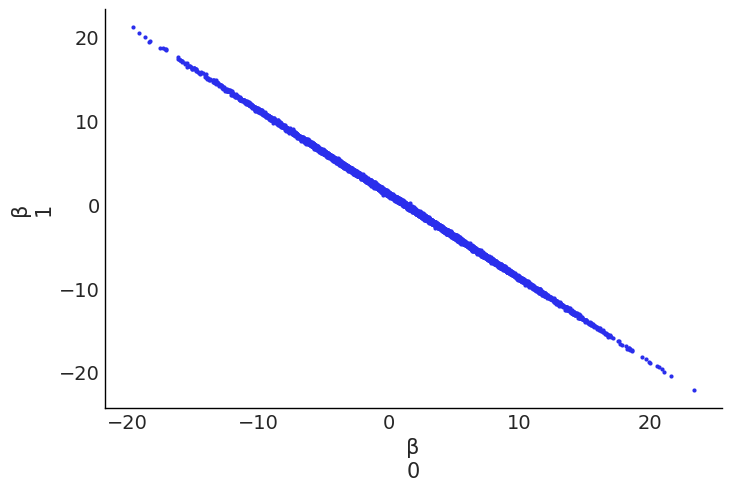

In [51]:
az.plot_pair(idata_red, var_names=['β'])
plt.savefig('B11197_03_25.png')

## Masking effect variables

In [52]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

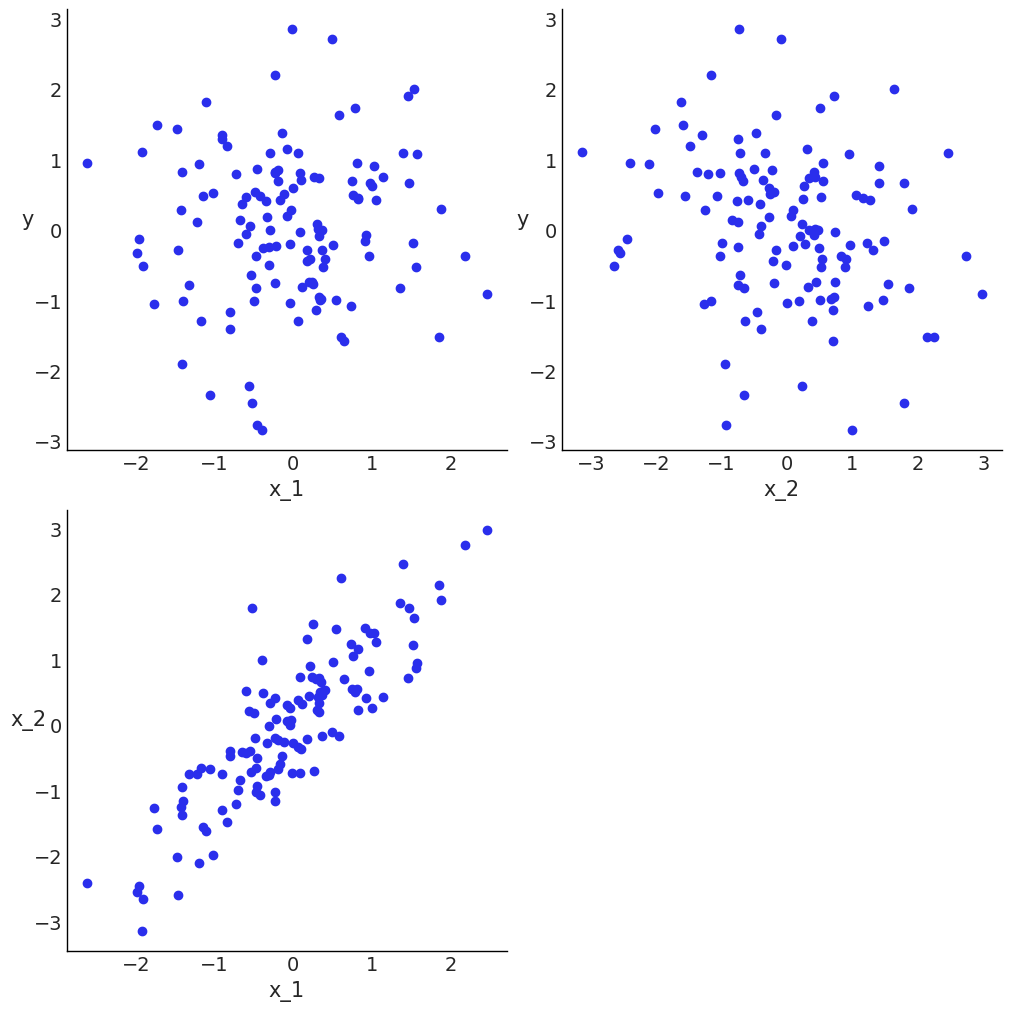

In [56]:
scatter_plot(X, y)
plt.savefig('B11197_03_26.png')

In [57]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_x1x2 = pm.sample(1000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_x1 = pm.sample(1000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_x2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, ϵ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, ϵ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β2, ϵ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


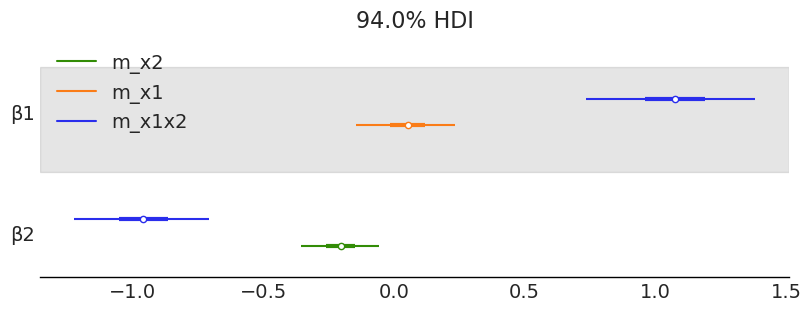

In [58]:
az.plot_forest([idata_x1x2, idata_x1, idata_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_27.png', bbox_inches='tight')

## Variable variance

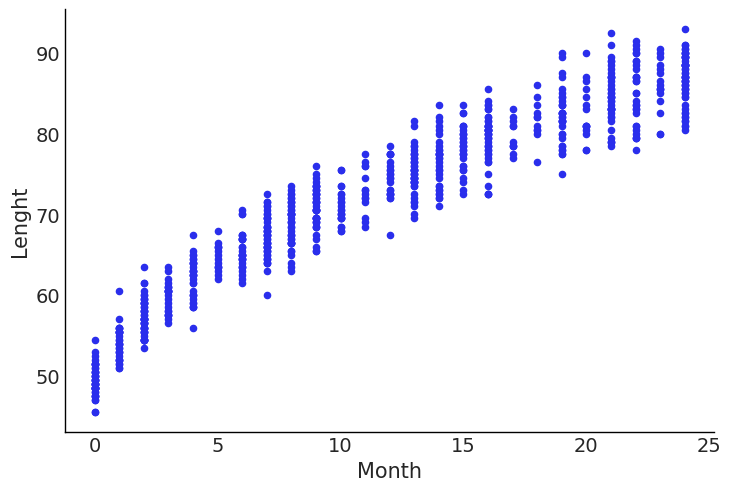

In [59]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')
plt.savefig('B11197_03_28.png')

In [60]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sigma=10)
    β = pm.Normal('β', sigma=10)
    γ = pm.HalfNormal('γ', sigma=10)
    δ = pm.HalfNormal('δ', sigma=10)

    x_shared = pm.MutableData("x_shared", data.Month.values.astype(float))

    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=data.Lenght)

    idata_vv = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


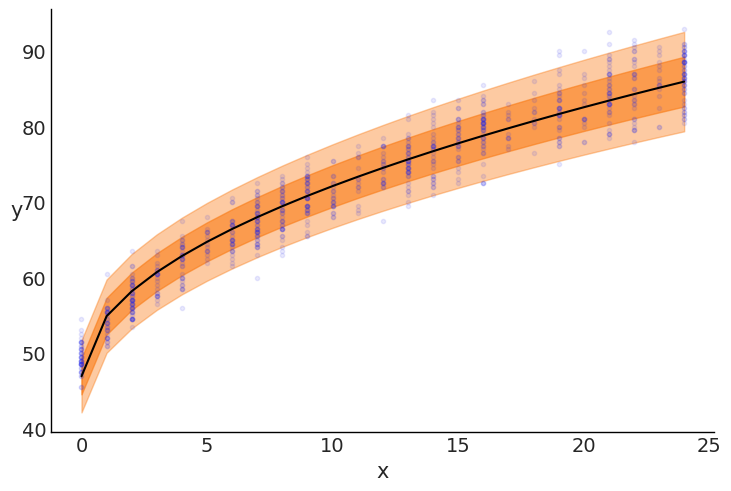

In [61]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

μ_m = idata_vv.posterior['μ'].mean(("chain", "draw")).values
ϵ_m = idata_vv.posterior['ϵ'].mean(("chain", "draw")).values

plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month,
                 μ_m + 1 * ϵ_m, μ_m - 1 * ϵ_m,
                 alpha=0.6, color='C1')
plt.fill_between(data.Month,
                 μ_m + 2 * ϵ_m, μ_m -2 * ϵ_m,
                 alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_29.png')

In [62]:
pm.set_data({"x_shared":[0.5]}, model=model_vv)
ppc = pm.sample_posterior_predictive(idata_vv, model=model_vv)
y_ppc = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw")).values

Sampling: [y_pred]


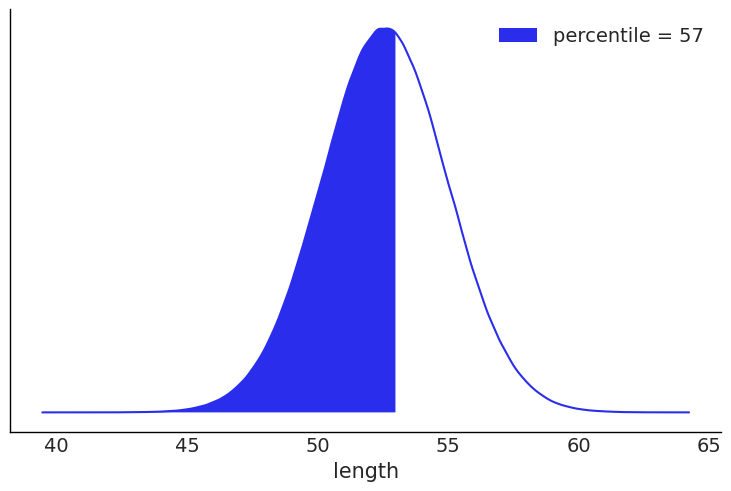

In [63]:
ref = 53
grid, pdf = az.kde(y_ppc)
plt.plot(grid, pdf)
percentile = int(np.mean(y_ppc <= ref) * 100)
plt.fill_between(grid[grid < ref],
                 pdf[grid < ref],
                 label=f'percentile = {percentile:2d}')
plt.xlabel('length')
plt.yticks([])
plt.legend()
plt.savefig('B11197_03_30.png')

In [64]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sigma=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sigma=ϵ, nu=ν, observed=y_4)
    idata_t2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
